# Config

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd '/content/drive/MyDrive/Credit Card Fraud Analysis'

/content/drive/MyDrive/Credit Card Fraud Analysis


In [3]:
from pyspark.sql import SparkSession
import os, sys, matplotlib.pyplot as plt, seaborn as sns
import pretty_errors
from pyspark.sql import functions as F
import pandas as pd, numpy as np
import pyspark.sql.functions as F

In [4]:
from config import PROJECT_PATH

In [11]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

In [5]:
from src.processing import *
from src.visualization import *
from src.metrics import *
from sklearn.metrics import classification_report

In [6]:
train_dir = os.path.join(PROJECT_PATH, 'input/train.parquet')
test_dir = os.path.join(PROJECT_PATH, 'input/test.parquet')

In [7]:
sc = SparkSession.builder \
    .appName("fraudDetection") \
    .config("spark.driver.maxResultSize", "3g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()
train = sc.read.parquet(train_dir, inferSchema = True, header = True)
test = sc.read.parquet(test_dir, inferSchema = True, header = True)

In [8]:
train, test = train.drop('_c0'), test.drop('_c0')

In [12]:
train.show()

+------+--------+-------+------------------+------------------+------------------+----+----------+-----+--------------------+-------------+--------+
|   amt|city_pop|    lat|              long|         merch_lat|        merch_long| age|trans_hour|state|            merchant|     category|is_fraud|
+------+--------+-------+------------------+------------------+------------------+----+----------+-----+--------------------+-------------+--------+
|  4.97|    3495|36.0788|          -81.1781|         36.011293|        -82.048315|36.0|         0|   NC|Rippin, Kub and Mann|     misc_net|       0|
|107.23|     149|48.8878|         -118.2105|49.159046999999994|       -118.186462|46.0|         0|   WA|Heller, Gutmann a...|  grocery_pos|       0|
|220.11|    4154|42.1808|          -112.262|         43.150704|       -112.154481|62.0|         0|   ID|      Lind-Buckridge|entertainment|       0|
|  45.0|    1939|46.2306|         -112.1138|         47.034331|       -112.561071|57.0|         0|   MT|Ku

In [13]:
print(f'Train shape: {train.count()}, {len(train.columns)}')
print(f'Test shape: {test.count()}, {len(test.columns)}')

Train shape: 1296675, 12
Test shape: 555719, 12


In [20]:
test.groupBy('is_fraud').count().show()

+--------+------+
|is_fraud| count|
+--------+------+
|       1|  2145|
|       0|553574|
+--------+------+



In [9]:
categorical_columns = ['state', 'merchant', 'category']
numerical_columns = ['log_amt', 'city_pop', 'lat', 'long', 'merch_lat', 'merch_long', 'age' ,'trans_hour']

In [12]:
log_transformer = LogTransformer(input_col = 'amt', output_col = 'log_amt')
multiplier = MultiplicationTransformer(input_cols = numerical_columns)
string_indexer = StringIndexer(inputCols = categorical_columns, outputCols = [f'{col}_idx' for col in categorical_columns])
encoder = OneHotEncoder(inputCols = [f'{col}_idx' for col in categorical_columns], outputCols = [f'{col}_vec' for col in categorical_columns])
assembler = VectorAssembler(inputCols = numerical_columns + multiplier.get_output_cols() + [f'{col}_vec' for col in categorical_columns], outputCol = 'features')
dct = DecisionTreeClassifier(labelCol = 'is_fraud', featuresCol = 'features')

# Training

## Original data

In [ ]:
pipeline = Pipeline(stages = [log_transformer, multiplier, string_indexer, encoder, assembler, dct])
pipeline_model = pipeline.fit(train)
transformed_train, transformed_test = pipeline_model.transform(train), pipeline_model.transform(test)

In [14]:
test_scores = transformed_test.select('is_fraud', 'prediction', 'probability').toPandas()

In [15]:
class_report = classification_report(y_true = test_scores['is_fraud'], y_pred = test_scores['prediction'])
print(f'Classification report for imbalanced data: \n {class_report}')

Classification report for imbalanced data: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.76      0.52      0.61      2145

    accuracy                           1.00    555719
   macro avg       0.88      0.76      0.81    555719
weighted avg       1.00      1.00      1.00    555719



In [16]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol = 'probability', labelCol = 'is_fraud', metricName = 'areaUnderROC')
roc = evaluator.evaluate(transformed_test)

print(f"Area under ROC curve: {roc:.4f}")

Area under ROC curve: 0.9550


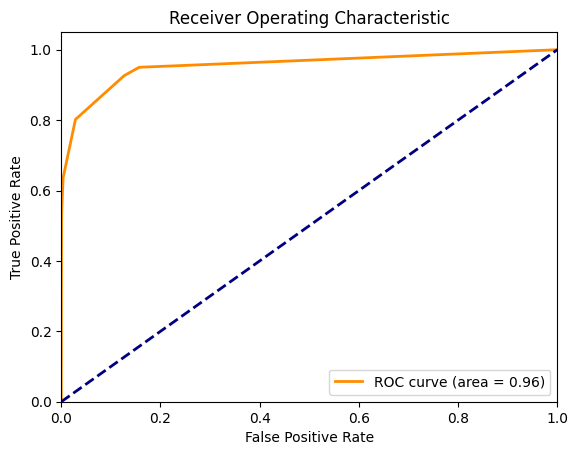

In [17]:
proba = test_scores['probability'].apply(lambda x: x[1])
roc_auc_curve(test_scores['is_fraud'], proba)

In [18]:
labels_and_preds = transformed_test.select(F.col('prediction').cast('double'), F.col('is_fraud').cast('double')) \
                              .rdd \
                              .map(lambda row: (row['prediction'], row['is_fraud']))
metrics = MulticlassMetrics(labels_and_preds)

Confusion Matrix for imbalanced data:


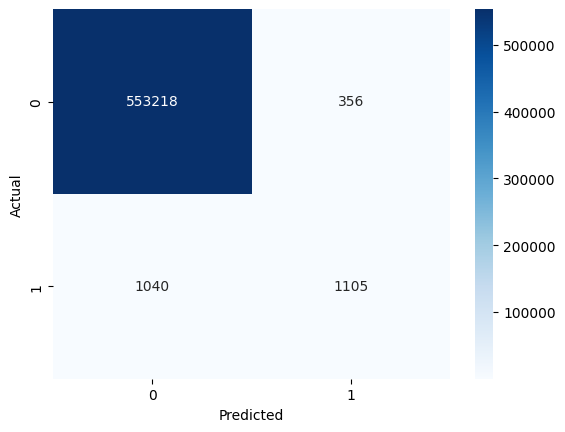

In [19]:
print('Confusion Matrix for imbalanced data:')
heatmap(metrics.confusionMatrix().toArray())

## Under-Sampling

In [21]:
minority_class, majority_class = train.where(F.col('is_fraud') == 1), train.where(F.col('is_fraud') == 0)
fraction = minority_class.count() / train.count()
fraction

0.005788651743883394

In [22]:
resampled_majority_class = majority_class.sample(withReplacement = False, fraction = fraction)
resampled_train = minority_class.union(resampled_majority_class)
resampled_train.groupby('is_fraud').count().show()

+--------+-----+
|is_fraud|count|
+--------+-----+
|       1| 7506|
|       0| 7481|
+--------+-----+



In [ ]:
pipeline_model = pipeline.fit(resampled_train)
train_preds, test_preds = pipeline_model.transform(resampled_train), pipeline_model.transform(test)